## Jayden Yap p2112790 CA1 Part A (Classification)

### Setup
Let's import our modules and data, and then take a look at the data to understand it

In [1]:
#dependencies
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.metrics import accuracy_score,confusion_matrix,plot_confusion_matrix,f1_score,recall_score
from sklearn.model_selection import cross_val_score,cross_val_predict
import matplotlib.pyplot as plt

In [2]:
#import dataset
factoryData=pd.read_csv('data/factory_data (classification).csv')
display(factoryData.head(3))
display(factoryData.tail(3))
print(factoryData.info())
#Columns UniqueID and ProductID are redundant for our model so we can remove them
#Quality column is categorical with 3 values ('L' for low, 'M' for medium, 'H' for high) indicating quality of machine
#Ambient and process T indicate temperatures of machines recorded when idle, and then when being used. If we get the difference between the 2 we get the temperature rise caused by machine
#Rotation speed(rpm) is number of revolutions per minute of machine. Type of machine is unknown but it is likely to be a fan/turbine/motor of some sort. 
#Tool wear(min) is the estimated number of minutes the machine can operate before being broken.
#Machine status indicates whether the machine is broken (1) or still working (0)

,Unique ID,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
0,1,K12965,M,24.95,35.45,1551.0,42.8,0,0
1,2,Z62710,L,25.05,35.55,1408.0,46.3,3,0
2,3,T20224,L,24.95,35.35,1498.0,49.4,5,0


,Unique ID,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
19997,19998,T83921,M,25.95,NaN,NaN,33.4,22,0
19998,19999,K42424,H,25.95,35.65,1408.0,48.5,25,0
19999,20000,Z10048,M,25.95,35.65,1500.0,40.2,30,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unique ID             20000 non-null  int64  
 1   Product ID            20000 non-null  object 
 2   Quality               19009 non-null  object 
 3   Ambient T (C)         20000 non-null  float64
 4   Process T (C)         19600 non-null  float64
 5   Rotation Speed (rpm)  18812 non-null  float64
 6   Torque (Nm)           20000 non-null  float64
 7   Tool Wear (min)       20000 non-null  int64  
 8   Machine Status        20000 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 1.4+ MB
None


### Data Cleaning and Processing

We need to turn our data into features (real numbered vectors)

Let's clean up our data. Then we'll impute missing values and create new columns using existing ones (feature engineering)

In [3]:
#remove redundant columns
df=factoryData[['Quality','Ambient T (C)','Process T (C)','Rotation Speed (rpm)','Torque (Nm)','Tool Wear (min)', 'Machine Status']]
#change dtype to categorical
df["Quality"] = df["Quality"].astype('category')
c=df["Quality"]
#map our encoded values with dictionary
d = dict(enumerate(c.cat.categories))
d[0]='L'
d[1]='M'
d[2]='H'

inv_map = {v: k for k, v in d.items()} #inverse keys and values
df["Quality"]=df["Quality"].map(inv_map)
df["Quality"]=df["Quality"].astype('float64') #convert back to float
df.Quality


0        1.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
19995    1.0
19996    2.0
19997    1.0
19998    2.0
19999    1.0
Name: Quality, Length: 20000, dtype: float64

In [4]:
#Enginering feature
#Ambient Temp and Process Temp is paired variables, let's create a column which is the difference between these two values (i.e: Rise in Temperature)
df['TRise']=df['Process T (C)']-df['Ambient T (C)']
df=df[['Quality','TRise','Rotation Speed (rpm)','Torque (Nm)','Tool Wear (min)', 'Machine Status']]
df.columns=['Quality','TRise','RotationSpeed','TorqueForce','Lifespan','Status']
df

,Quality,TRise,RotationSpeed,TorqueForce,Lifespan,Status
0,1.0,10.5,1551.0,42.8,0,0
1,0.0,10.5,1408.0,46.3,3,0
2,0.0,10.4,1498.0,49.4,5,0
3,0.0,10.4,1433.0,39.5,7,0
4,0.0,10.5,1408.0,40.0,9,0
...,...,...,...,...,...,...
19995,1.0,9.6,NaN,29.5,14,0
19996,2.0,9.5,1632.0,31.8,17,0
19997,1.0,NaN,NaN,33.4,22,0
19998,2.0,9.7,1408.0,48.5,25,0


#### Imputing missing values
we will split data before actual imputation to prevent data leakage

In [5]:
#Take a look at lifespan column sorted by ascending order
print(df.Lifespan.sort_values().head(242)) 
#about 240 rows with '0' Lifespan! we know that this is the estimated lifespan so it does not make sense for it to be 0. 
#it is likely that these values are actually null, so let's turn these values into nulls
df['Lifespan'] = df['Lifespan'].replace({'0':np.nan, 0:np.nan})

0        0
7940     0
15910    0
3612     0
1510     0
        ..
19497    0
8440     0
9175     0
17169    2
14648    2
Name: Lifespan, Length: 242, dtype: int64


In [6]:
#Check for null values
print(pd.isnull(df).sum())
print(f"Total rows with null values: {df.isnull().any(axis=1).sum()}")

Quality           991
TRise             400
RotationSpeed    1188
TorqueForce         0
Lifespan          240
Status              0
dtype: int64
Total rows with null values: 2687


In [7]:
#before we impute our missing values it is important to split our data(avoid data leakage)
# Create train and test sets (test set becomes holdout set for testing later)
X=df.drop('Status',axis=1)
y=df['Status']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,stratify=y
                                                    ,random_state=1 #fixed splits
                                                    )

In [8]:
#if we deleted all rows with null values (2687 rows), we would be deleting more than 10% of our dataset, so let's try to impute missing values 
#First, simple impute for missing values in 'Quality' (using mode)
from sklearn.impute import SimpleImputer
SImp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
SImp.fit(X_train[['Quality']])
#impute both train and test data based on training data
X_train["Quality"]=SImp.transform(X_train[['Quality']]).ravel()
X_test["Quality"]=SImp.transform(X_test[['Quality']]).ravel()
#imputation done
#Check for null values
print("********TRAIN DATA*********")
print(pd.isnull(X_train).sum())
print(f"Total rows with null values: {X_train.isnull().any(axis=1).sum()}\n")

print('********TEST DATA*********')
print(pd.isnull(X_test).sum())
print(f"Total rows with null values: {X_test.isnull().any(axis=1).sum()}")

********TRAIN DATA*********
Quality            0
TRise            266
RotationSpeed    792
TorqueForce        0
Lifespan         152
dtype: int64
Total rows with null values: 1175

********TEST DATA*********
Quality            0
TRise            134
RotationSpeed    396
TorqueForce        0
Lifespan          88
dtype: int64
Total rows with null values: 603


In [9]:
#now we will impute the missing values in numerical columns (TRise and RotationSpeed and Lifespan) using IterativeImputer (takes into account other columns)
columnsBackup=X_train.columns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)
#transform both train and test data
X_train=pd.DataFrame(imp.transform(X_train))
X_train.columns=columnsBackup #restore column names

X_test=pd.DataFrame(imp.transform(X_test))
X_test.columns=columnsBackup #restore column names

#Check for null values
print("********TRAIN DATA*********")
print(pd.isnull(X_train).sum())
print(f"Total rows with null values: {X_train.isnull().any(axis=1).sum()}\n")

print('********TEST DATA*********')
print(pd.isnull(X_test).sum())
print(f"Total rows with null values: {X_test.isnull().any(axis=1).sum()}")

********TRAIN DATA*********
Quality          0
TRise            0
RotationSpeed    0
TorqueForce      0
Lifespan         0
dtype: int64
Total rows with null values: 0

********TEST DATA*********
Quality          0
TRise            0
RotationSpeed    0
TorqueForce      0
Lifespan         0
dtype: int64
Total rows with null values: 0


#### More Feature Engineering

In [10]:
#Creating 'efficiency' column: defined as RotationSpeed/TorqueForce (output/input)
X_train['Efficiency']=X_train['RotationSpeed']/X_train['TorqueForce']
X_train=X_train[['Quality','TRise','RotationSpeed','TorqueForce','Efficiency','Lifespan']]
#repeat for test data
X_test['Efficiency']=X_test['RotationSpeed']/X_test['TorqueForce']
X_test=X_test[['Quality','TRise','RotationSpeed','TorqueForce','Efficiency','Lifespan']]

In [11]:
#let's reencode our 'Quality' column using one hot encoder (splits into 3 columns)
# importing one hot encoder 
from sklearn.preprocessing import OneHotEncoder
# creating one hot encoder object 
onehotencoder = OneHotEncoder(drop='first')
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
encoded = onehotencoder.fit_transform(X_train.Quality.values.reshape(-1,1)).toarray()
dfX=pd.DataFrame(encoded,columns=['QualMedium','QualHigh'])
#To add this back into the original dataframe 
X_train = pd.concat([X_train, dfX], axis=1)
#droping the Quality column 
X_train= X_train.drop(['Quality'], axis=1) 
#Reorder
X_train=X_train[["QualMedium","QualHigh","TRise","RotationSpeed","TorqueForce","Efficiency","Lifespan"]]

#repeat for test data
encoded = onehotencoder.fit_transform(X_test.Quality.values.reshape(-1,1)).toarray()
dfX=pd.DataFrame(encoded,columns=['QualMedium','QualHigh'])
X_test = pd.concat([X_test, dfX], axis=1)
X_test= X_test.drop(['Quality'], axis=1) 
X_test=X_test[["QualMedium","QualHigh","TRise","RotationSpeed","TorqueForce","Efficiency","Lifespan"]]

#printing to verify 
print(X_train.head())
print(X_test.head())

   QualMedium  QualHigh  TRise  RotationSpeed  TorqueForce  Efficiency  \
0         1.0       0.0   11.1         1492.0         41.7   35.779376   
1         1.0       0.0   10.1         1924.0         22.6   85.132743   
2         0.0       0.0   10.9         1607.0         37.7   42.625995   
3         0.0       0.0   10.6         1645.0         31.1   52.893891   
4         1.0       0.0    9.5         1432.0         49.0   29.224490   

   Lifespan  
0     100.0  
1     193.0  
2      49.0  
3     169.0  
4     218.0  
   QualMedium  QualHigh  TRise  RotationSpeed  TorqueForce  Efficiency  \
0         0.0       0.0   11.1         1513.0         39.7   38.110831   
1         1.0       0.0   10.4         1423.0         49.5   28.747475   
2         0.0       0.0   11.4         1562.0         36.8   42.445652   
3         1.0       0.0    8.9         1557.0         33.8   46.065089   
4         0.0       0.0    8.9         1418.0         46.6   30.429185   

   Lifespan  
0      32.0 

#### Oversampling
Our dataset is very inbalanced (678 broken machines out of 20,000), let's oversample to make the distribution more even to reduce biasness later
This creates new rows of data of broken machines such that roughly half of our final dataset will be broken machines instead of less than 5%

In [12]:
#install package if needed (for oversampling)
#!pip install imblearn --user
#or
#!conda install -c conda-forge imbalanced-learnc

In [13]:
#its important to oversample only on training data so we don't contaminate test data
from imblearn.over_sampling import RandomOverSampler 
ros = RandomOverSampler(random_state=1)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

### Data Visualisation

Let's understand the relationships within our data better with graphs

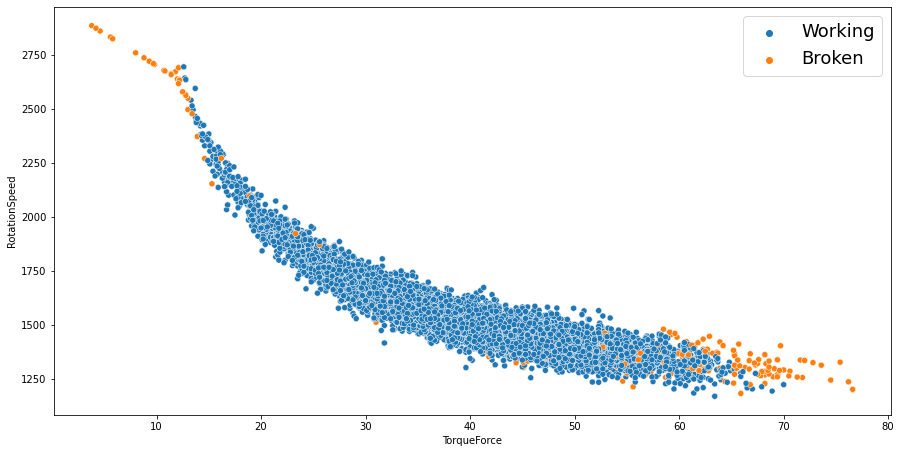

In [15]:
#let's try to look for correlations between our features and target variable (status)
plt.figure(figsize=(15,7.5))
ax=sns.scatterplot(data=df,x='TorqueForce',y='RotationSpeed',hue='Status')
handles, labels  =  ax.get_legend_handles_labels()
ax.legend(handles, ['Working', 'Broken'],prop={'size':18})
plt.show()
#here we can see a very obvious correlation between rotation speed and torque
#when torque force increases, rotation speed decreases non-linearly.
#looking at the colours, we can see that many of the broken machines either have very low torque force or very high torque force

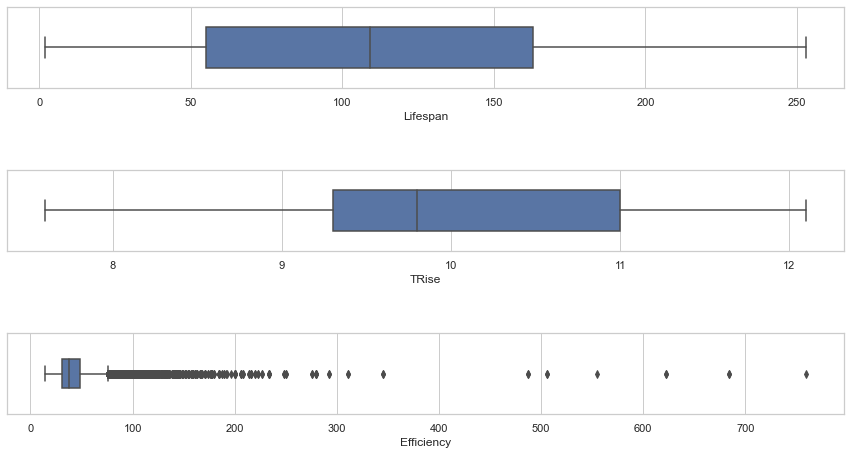

In [24]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,7.5))
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(3,1,1)
sns.boxplot('Lifespan',data=df,width=0.5)
#plt.title('Lifespan')
plt.subplot(3,1,2)
sns.boxplot('TRise',data=df,width=0.5)
#plt.title('Temperature Rise')
plt.subplot(3,1,3)
combineDF=pd.concat([X_train,X_test])
sns.boxplot('Efficiency',data=combineDF,width=0.35)
#plt.title('Efficiency')
plt.show()
#Efficiency boxplot is very skewed to the right
#this means there are some machines with much higher efficiency than the rest (rotationspeed/torqueforce)
#NOTE: effienciency is not a %, just a general measure 

% of Low quality machines that were BROKEN: 3.91%
% of Medium quality machines that were BROKEN: 2.79%
% of High quality machines that were BROKEN: 2.13%


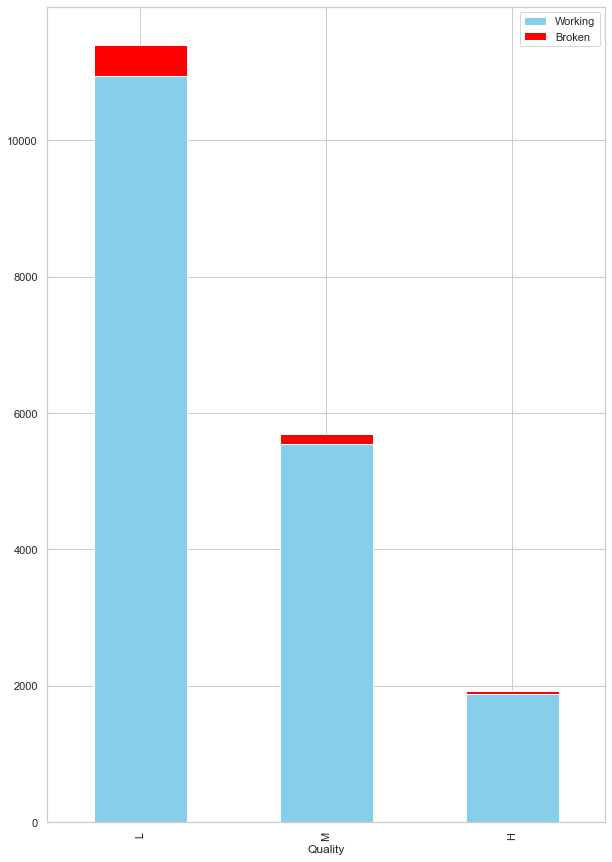

In [25]:
sns.set_theme(style="whitegrid")
dfPlot = factoryData.groupby(['Quality', 'Machine Status']).size().reset_index().pivot(columns='Quality', index='Machine Status', values=0)
dfPlot= dfPlot.transpose()
dfPlot=dfPlot.reindex(["L","M","H"])
#calculate % broken in each quality category
dfBroken=(dfPlot[1]/(dfPlot[0]+dfPlot[1]))*100
#display it
qualities=['Low','Medium','High']
i=0
for percent in dfBroken:
    print(f'% of {qualities[i]} quality machines that were BROKEN: {percent:.2f}%')
    i+=1

#plot stacked bar graph
ax=dfPlot.plot.bar(stacked=True, color=['skyblue','red'],figsize=(10, 15))
ax.legend(["Working","Broken"])
plt.show()
#we can see that majority of machines are low quality, next most common is medium, then high quality.
#the higher the category, the less machines were broken (makes sense)

### Testing Models
We will try many models at default settings, then we take the best performing 3 models to perform hyperparameter tuning on

In [34]:
#dictionary to store accuracy scores
scoreList={}

#### Random Forest

Normal

0.8928571428571429


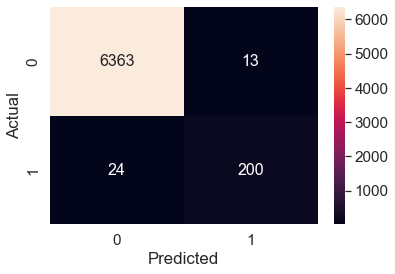

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6376
           1       0.94      0.89      0.92       224

    accuracy                           0.99      6600
   macro avg       0.97      0.95      0.96      6600
weighted avg       0.99      0.99      0.99      6600



In [35]:
#trying random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=1)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
#scoring
accuracy=recall_score(y_test,y_pred)
print(accuracy)
scoreList['RandomForest']=accuracy
#confusion matrix
cm = confusion_matrix(y_test,y_pred)
sns.set(font_scale=1.4) # for label size
ax=sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
ax.set(xlabel='Predicted',ylabel='Actual')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))
#without much tuning,already high performance from random forest model, no instances of broken machines being misclassified. Only 9 working machines were classified as broken. 

Oversampled

0.9017857142857143


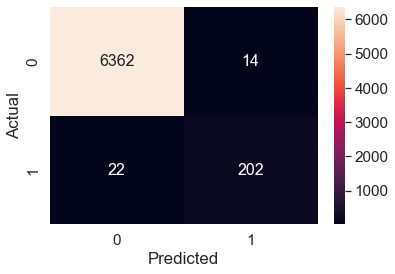

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6376
           1       0.94      0.90      0.92       224

    accuracy                           0.99      6600
   macro avg       0.97      0.95      0.96      6600
weighted avg       0.99      0.99      0.99      6600



In [36]:
#trying random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=1)
clf.fit(X_ros, y_ros)
y_pred=clf.predict(X_test)
#scoring
accuracy=recall_score(y_test,y_pred)
print(accuracy)
scoreList['RandomForestOS']=accuracy
#confusion matrix
cm = confusion_matrix(y_test,y_pred)
sns.set(font_scale=1.4) # for label size
ax=sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
ax.set(xlabel='Predicted',ylabel='Actual')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))
#without much tuning,already high performance from random forest model, no instances of broken machines being misclassified. Only 9 working machines were classified as broken. 

#### AdaBoost
Adaptive boost uses multiple classifiers together

Normal

0.46875


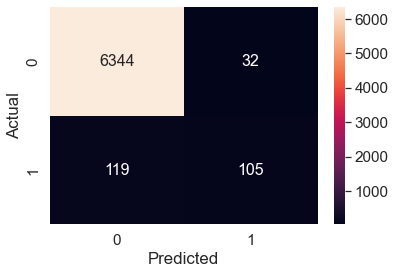

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6376
           1       0.77      0.47      0.58       224

    accuracy                           0.98      6600
   macro avg       0.87      0.73      0.78      6600
weighted avg       0.97      0.98      0.97      6600



In [37]:
#trying adaboost
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(random_state=1)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
#scoring
accuracy=recall_score(y_test,y_pred)
print(accuracy)
scoreList['AdaBoost']=accuracy
#confusion matrix
cm = confusion_matrix(y_test,y_pred)
sns.set(font_scale=1.4) # for label size
ax=sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
ax.set(xlabel='Predicted',ylabel='Actual')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

#from confusion matrix, 19 broken machines were misclassified. 510 working machines were classified as broken. Good performance

Oversampled

0.9107142857142857


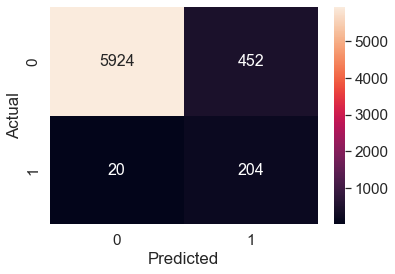

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      6376
           1       0.31      0.91      0.46       224

    accuracy                           0.93      6600
   macro avg       0.65      0.92      0.71      6600
weighted avg       0.97      0.93      0.94      6600



In [38]:
#trying adaboost
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(random_state=1)
clf.fit(X_ros, y_ros)
y_pred=clf.predict(X_test)
#scoring
accuracy=recall_score(y_test,y_pred)
print(accuracy)
scoreList['AdaBoostOS']=accuracy
#confusion matrix
cm = confusion_matrix(y_test,y_pred)
sns.set(font_scale=1.4) # for label size
ax=sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
ax.set(xlabel='Predicted',ylabel='Actual')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

#from confusion matrix, 19 broken machines were misclassified. 510 working machines were classified as broken. Good performance

#### Gradient Boost

Normal

0.7544642857142857


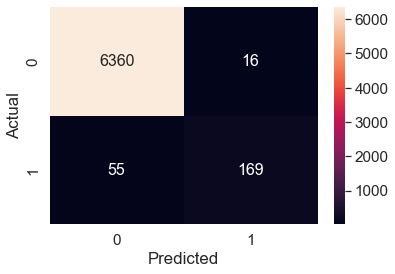

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6376
           1       0.91      0.75      0.83       224

    accuracy                           0.99      6600
   macro avg       0.95      0.88      0.91      6600
weighted avg       0.99      0.99      0.99      6600



In [39]:
#trying GradientBoost
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=1)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
#scoring
accuracy=recall_score(y_test,y_pred)
print(accuracy)
scoreList['GradBoost']=accuracy
#confusion matrix
cm = confusion_matrix(y_test,y_pred)
sns.set(font_scale=1.4) # for label size
ax=sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
ax.set(xlabel='Predicted',ylabel='Actual')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

#Great performance

Oversampled

0.9285714285714286


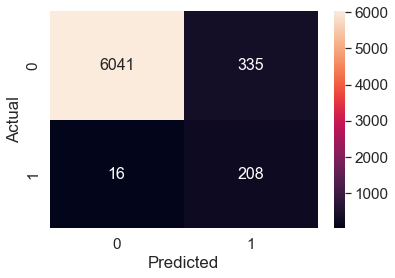

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      6376
           1       0.38      0.93      0.54       224

    accuracy                           0.95      6600
   macro avg       0.69      0.94      0.76      6600
weighted avg       0.98      0.95      0.96      6600



In [40]:
#trying GradientBoost
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=1)
clf.fit(X_ros, y_ros)
y_pred=clf.predict(X_test)
#scoring
accuracy=recall_score(y_test,y_pred)
print(accuracy)
scoreList['GradBoostOS']=accuracy
#confusion matrix
cm = confusion_matrix(y_test,y_pred)
sns.set(font_scale=1.4) # for label size
ax=sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
ax.set(xlabel='Predicted',ylabel='Actual')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

#Great performance

#### Logistic Regression
models probability of discrete outcomes

Normal

0.26785714285714285


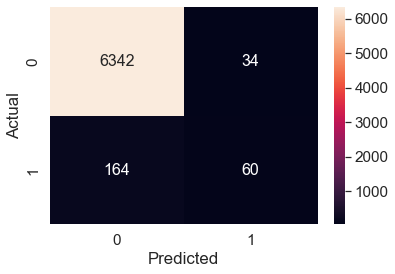

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6376
           1       0.64      0.27      0.38       224

    accuracy                           0.97      6600
   macro avg       0.81      0.63      0.68      6600
weighted avg       0.96      0.97      0.96      6600



In [41]:
#trying logreg
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=1)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
#scoring
accuracy=recall_score(y_test,y_pred)
print(accuracy)
scoreList['LogReg']=accuracy
#confusion matrix
cm = confusion_matrix(y_test,y_pred)
sns.set(font_scale=1.4) # for label size
ax=sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
ax.set(xlabel='Predicted',ylabel='Actual')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

#Bad results

Oversampled

0.8526785714285714


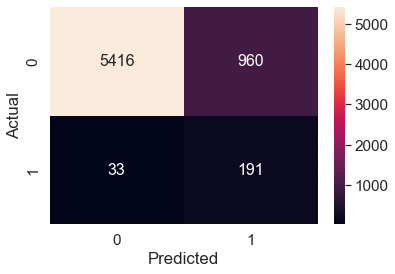

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      6376
           1       0.17      0.85      0.28       224

    accuracy                           0.85      6600
   macro avg       0.58      0.85      0.60      6600
weighted avg       0.97      0.85      0.89      6600



In [42]:
#trying logreg
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=1)
clf.fit(X_ros, y_ros)
y_pred=clf.predict(X_test)
#scoring
accuracy=recall_score(y_test,y_pred)
print(accuracy)
scoreList['LogRegOS']=accuracy
#confusion matrix
cm = confusion_matrix(y_test,y_pred)
sns.set(font_scale=1.4) # for label size
ax=sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
ax.set(xlabel='Predicted',ylabel='Actual')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

#Still decent results, however most misclassifications were for working machines

#### K Nearest Neighbors

Normal

0.3482142857142857


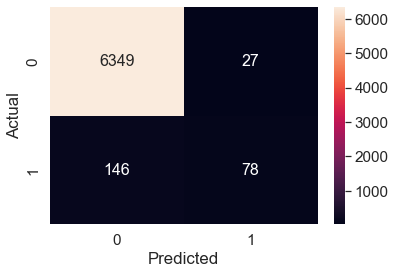

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6376
           1       0.74      0.35      0.47       224

    accuracy                           0.97      6600
   macro avg       0.86      0.67      0.73      6600
weighted avg       0.97      0.97      0.97      6600



In [43]:
#trying kneighbors
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
#scoring
accuracy=recall_score(y_test,y_pred)
print(accuracy)
scoreList['KNN']=accuracy
#confusion matrix
cm = confusion_matrix(y_test,y_pred)
sns.set(font_scale=1.4) # for label size
ax=sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
ax.set(xlabel='Predicted',ylabel='Actual')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

#Actually bad results with KNN, oversampling should improve

Oversampled

0.78125


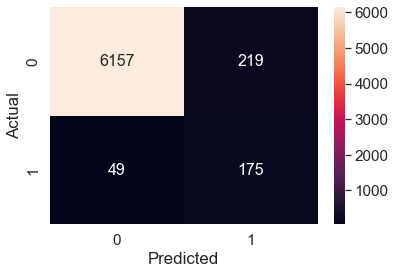

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      6376
           1       0.44      0.78      0.57       224

    accuracy                           0.96      6600
   macro avg       0.72      0.87      0.77      6600
weighted avg       0.97      0.96      0.96      6600



In [44]:
#trying kneighbors
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
clf.fit(X_ros, y_ros)
y_pred=clf.predict(X_test)
#scoring
accuracy=recall_score(y_test,y_pred)
print(accuracy)
scoreList['KNNOS']=accuracy
#confusion matrix
cm = confusion_matrix(y_test,y_pred)
sns.set(font_scale=1.4) # for label size
ax=sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
ax.set(xlabel='Predicted',ylabel='Actual')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

#Much better results after oversampling

#### Naive Bayes

Normal

0.16964285714285715


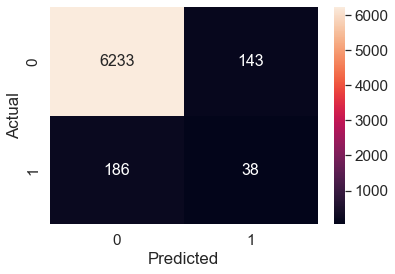

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      6376
           1       0.21      0.17      0.19       224

    accuracy                           0.95      6600
   macro avg       0.59      0.57      0.58      6600
weighted avg       0.95      0.95      0.95      6600



In [45]:
#trying naive bayes
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
#scoring
accuracy=recall_score(y_test,y_pred)
print(accuracy)
scoreList['NaiveBayes']=accuracy
#confusion matrix
cm = confusion_matrix(y_test,y_pred)
sns.set(font_scale=1.4) # for label size
ax=sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
ax.set(xlabel='Predicted',ylabel='Actual')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

#Terrible results but computation was very fast (less than a second)

Oversampled

0.6071428571428571


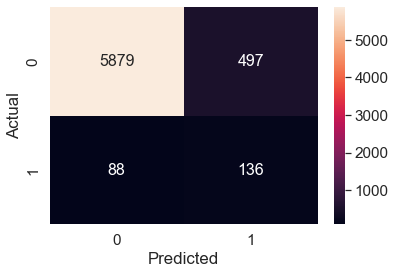

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      6376
           1       0.21      0.61      0.32       224

    accuracy                           0.91      6600
   macro avg       0.60      0.76      0.63      6600
weighted avg       0.96      0.91      0.93      6600



In [46]:
#trying naive bayes
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_ros, y_ros)
y_pred=clf.predict(X_test)
#scoring
accuracy=recall_score(y_test,y_pred)
print(accuracy)
scoreList['NaiveBayesOS']=accuracy
#confusion matrix
cm = confusion_matrix(y_test,y_pred)
sns.set(font_scale=1.4) # for label size
ax=sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
ax.set(xlabel='Predicted',ylabel='Actual')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

#Bad results but a HUGE improvement from earlier using normal data, oversampling helped a lot computation was very fast (less than a second)

#### Linear Discriminant Analysis (LDA)
linear decision boundary, assuming all classes have same covariance matrix (C)

Normal

0.3125


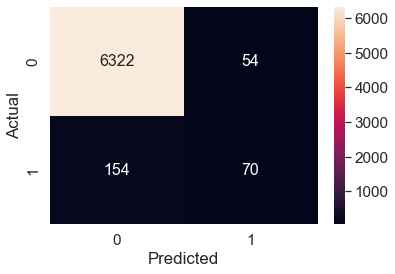

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6376
           1       0.56      0.31      0.40       224

    accuracy                           0.97      6600
   macro avg       0.77      0.65      0.69      6600
weighted avg       0.96      0.97      0.96      6600



In [47]:
#trying LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
clf = LDA()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
#scoring
accuracy=recall_score(y_test,y_pred)
print(accuracy)
scoreList['LDA']=accuracy
#confusion matrix
cm = confusion_matrix(y_test,y_pred)
sns.set(font_scale=1.4) # for label size
ax=sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
ax.set(xlabel='Predicted',ylabel='Actual')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

#Bad result

Oversampled

0.8303571428571429


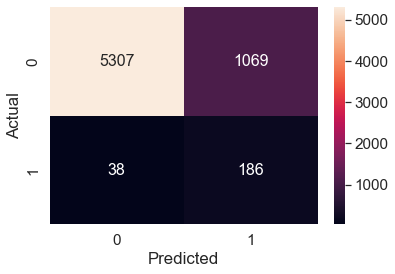

              precision    recall  f1-score   support

           0       0.99      0.83      0.91      6376
           1       0.15      0.83      0.25       224

    accuracy                           0.83      6600
   macro avg       0.57      0.83      0.58      6600
weighted avg       0.96      0.83      0.88      6600



In [48]:
#trying LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
clf = LDA()
clf.fit(X_ros, y_ros)
y_pred=clf.predict(X_test)
#scoring
accuracy=recall_score(y_test,y_pred)
print(accuracy)
scoreList['LDAOS']=accuracy
#confusion matrix
cm = confusion_matrix(y_test,y_pred)
sns.set(font_scale=1.4) # for label size
ax=sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
ax.set(xlabel='Predicted',ylabel='Actual')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

#Bad result

#### Quadratic Discriminant Analysis (QDA)
Non-linear decision boundary, assumes that each class have different covariances

Normal

0.25


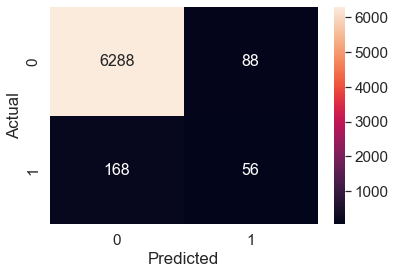

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6376
           1       0.39      0.25      0.30       224

    accuracy                           0.96      6600
   macro avg       0.68      0.62      0.64      6600
weighted avg       0.95      0.96      0.96      6600



In [49]:
#trying QDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
clf = QDA()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
#scoring
accuracy=recall_score(y_test,y_pred)
print(accuracy)
scoreList['QDA']=accuracy
#confusion matrix
cm = confusion_matrix(y_test,y_pred)
sns.set(font_scale=1.4) # for label size
ax=sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
ax.set(xlabel='Predicted',ylabel='Actual')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

#quite bad performance
#treated about half broken machines as working, but some working machines were classified as broken, quite strange

Oversampled

0.5223214285714286


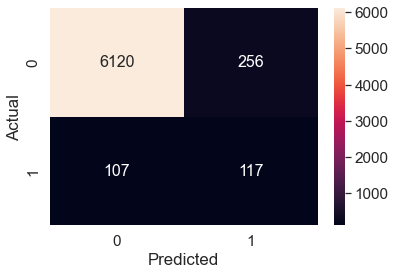

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6376
           1       0.31      0.52      0.39       224

    accuracy                           0.94      6600
   macro avg       0.65      0.74      0.68      6600
weighted avg       0.96      0.94      0.95      6600



In [50]:
#trying QDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
clf = QDA()
clf.fit(X_ros, y_ros)
y_pred=clf.predict(X_test)
#scoring
accuracy=recall_score(y_test,y_pred)
print(accuracy)
scoreList['QDAOS']=accuracy
#confusion matrix
cm = confusion_matrix(y_test,y_pred)
sns.set(font_scale=1.4) # for label size
ax=sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
ax.set(xlabel='Predicted',ylabel='Actual')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

#quite bad performance
#treated about half broken machines as working, but some working machines were classified as broken, quite strange

#### Evaluate Performance

In [51]:
#see the best models
sort_by_value = dict(sorted(scoreList.items(), key=lambda item: item[1],reverse=True))
print(sort_by_value)

{'GradBoostOS': 0.9285714285714286, 'AdaBoostOS': 0.9107142857142857, 'RandomForestOS': 0.9017857142857143, 'RandomForest': 0.8928571428571429, 'LogRegOS': 0.8526785714285714, 'LDAOS': 0.8303571428571429, 'KNNOS': 0.78125, 'GradBoost': 0.7544642857142857, 'NaiveBayesOS': 0.6071428571428571, 'QDAOS': 0.5223214285714286, 'AdaBoost': 0.46875, 'KNN': 0.3482142857142857, 'LDA': 0.3125, 'LogReg': 0.26785714285714285, 'QDA': 0.25, 'NaiveBayes': 0.16964285714285715}


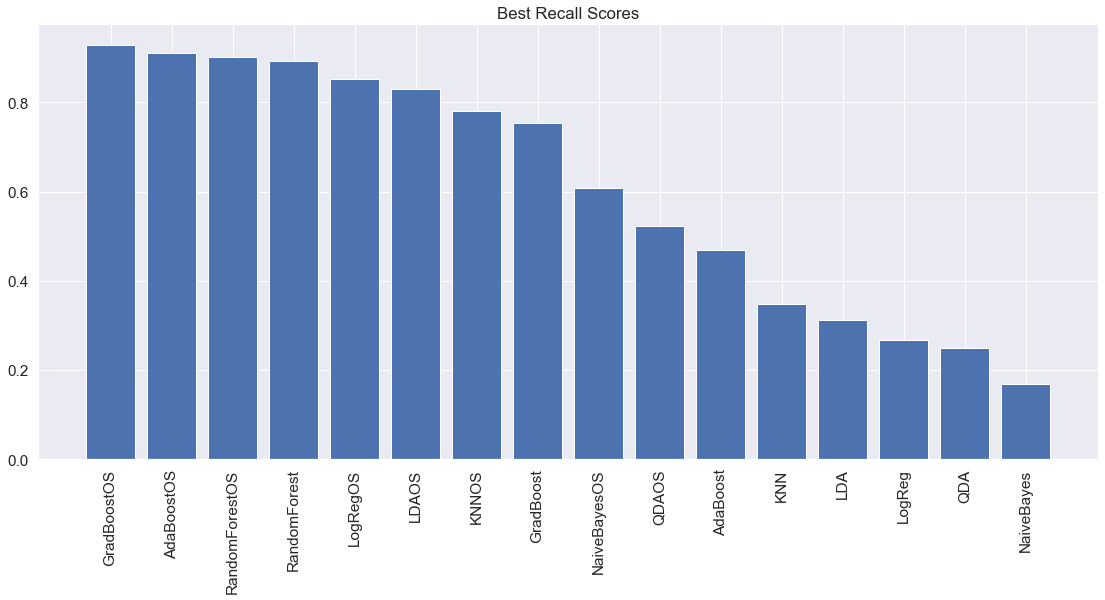

In [52]:
plt.figure(figsize=(19,8))
plt.bar(*zip(*sort_by_value.items()))
plt.xticks(rotation='vertical')
plt.title('Best Recall Scores')
plt.show()
#we can see oversampling improved scores for almost all models

### Improving Models
From the initial tests, the top 3 models were:
-GradBoost
-AdaBoost
-RandomForest
Let's do Hyperparameter tuning to improve them

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
finalScoreList={}
featureList=X_ros.columns

#### Random Forest

In [253]:
# Create the random grid
param_grid = {
    'n_estimators': [100],
    'max_features':['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(5, 30, num = 6)],
    'min_samples_split': [5, 8, 10, 15],
    'min_samples_leaf': [1, 2, 4, 5],
    'bootstrap': [True, False],
    'random_state': [1]
}
               
#instantiate classifier
clf=RandomForestClassifier()
clf_cv = GridSearchCV(clf, param_grid, cv=3,scoring='recall')
clf_cv.fit(X_ros,y_ros)

#Output
print(f"Tuned Random Forest Parameters: {clf_cv.best_params_}") 
print(f"Best score is {clf_cv.best_score_}")
#score of 1.0 is very optimistic due to CV (testing on oversampled data)

Tuned Random Forest Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 1}
Best score is 1.0


Most important Features
{'Efficiency': 0.24428664054740815, 'TorqueForce': 0.22905336907720816, 'Lifespan': 0.21244450536713808, 'RotationSpeed': 0.18484673761461776, 'TRise': 0.11981044187302256, 'QualMedium': 0.00608867943514255, 'QualHigh': 0.003469626085462818}
0.9375


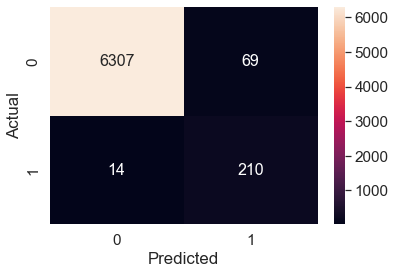

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6376
           1       0.75      0.94      0.83       224

    accuracy                           0.99      6600
   macro avg       0.88      0.96      0.91      6600
weighted avg       0.99      0.99      0.99      6600



In [59]:
#tuned Random Forest parameters
clfForest = RandomForestClassifier(bootstrap=True,max_depth=10,max_features='auto',min_samples_leaf=1,min_samples_split=5,n_estimators=300,random_state=1)
clfForest.fit(X_ros, y_ros) #fit training data

#Feature importance
importance = clfForest.feature_importances_
impDictFor=dict(zip(featureList, importance))
print("Most important Features")
print(dict(sorted(impDictFor.items(),key=lambda item: item[1],reverse=True)))

#use predict_proba method on test data to return probability of sample being in a particular class
forestPredProb=clfForest.predict_proba(X_test)[:,1]
forestPred=clfForest.predict(X_test)

# Generate ROC curve values: fpr, tpr, thresholds
fpr1, tpr1, thresholds1= roc_curve(y_test, forestPredProb)
auc1 = round(roc_auc_score(y_test, forestPredProb), 4)

#scoring
accuracy=recall_score(y_test,forestPred)
print(accuracy)
finalScoreList['RandomForest']=accuracy

#confusion matrix
cm = confusion_matrix(y_test,forestPred)
sns.set(font_scale=1.4) # for label size
ax=sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
ax.set(xlabel='Predicted',ylabel='Actual')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test,forestPred))

#Great result, improved from 0.89 to 0.93!

#### Gradient Boost

In [255]:
# Setup the hyperparameter grid
param_grid = {
    'n_estimators': [25,50,100,200,300,500],
    'learning_rate':[0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0],
    'random_state': [1]
}

#instantiate classifier
clf=GradientBoostingClassifier()
clf_cv = GridSearchCV(clf, param_grid, cv=3,scoring='recall')
clf_cv.fit(X_ros,y_ros)

#Output
print(f"Tuned GradientBoost Parameters: {clf_cv.best_params_}") 
print(f"Best score is {clf_cv.best_score_}")

Tuned GradientBoost Parameters: {'learning_rate': 0.25, 'n_estimators': 200, 'random_state': 1}
Best score is 1.0


Most important Features
{'Efficiency': 0.32046513552982137, 'Lifespan': 0.23179655687625042, 'TorqueForce': 0.1974398182505855, 'RotationSpeed': 0.1408678771817101, 'TRise': 0.10378669631556348, 'QualMedium': 0.004290712805714595, 'QualHigh': 0.0013532030403545527}
0.9151785714285714


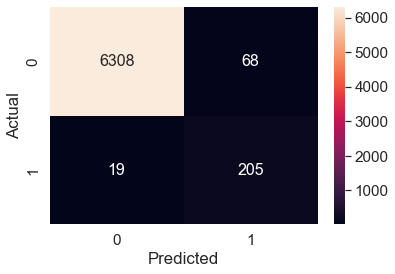

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6376
           1       0.75      0.92      0.82       224

    accuracy                           0.99      6600
   macro avg       0.87      0.95      0.91      6600
weighted avg       0.99      0.99      0.99      6600



In [60]:
#tuned GradientBoost test
clfGrad= GradientBoostingClassifier(n_estimators=200,learning_rate= 0.25,random_state=1)
clfGrad.fit(X_ros, y_ros)

#Feature importance
importance = clfGrad.feature_importances_
impDictGrad=dict(zip(featureList, importance))
print("Most important Features")
print(dict(sorted(impDictGrad.items(),key=lambda item: item[1],reverse=True)))

gradPredProb=clfGrad.predict_proba(X_test)[:,1]
gradPred=clfGrad.predict(X_test)

#roc score
fpr2, tpr2, thresholds2= roc_curve(y_test, gradPredProb)
auc2 = round(roc_auc_score(y_test, gradPredProb), 4)

#scoring
accuracy=recall_score(y_test,gradPred)
print(accuracy)
finalScoreList['GradientBoost']=accuracy
#confusion matrix
cm = confusion_matrix(y_test,gradPred)
sns.set(font_scale=1.4) # for label size
ax=sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
ax.set(xlabel='Predicted',ylabel='Actual')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test,gradPred))

#### Adaboost

In [248]:
# Setup the hyperparameter grid
param_grid = {
    'n_estimators': [25,50,100,200,300,500],
    'learning_rate':[0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0],
    'random_state': [1]
}

#instantiate classifier
clf=AdaBoostClassifier()
clf_cv = GridSearchCV(clf, param_grid, cv=3,scoring='recall')
clf_cv.fit(X_ros,y_ros)

#Output
print(f"Tuned Adaboost Parameters: {clf_cv.best_params_}") 
print(f"Best score is {clf_cv.best_score_}")

Tuned Adaboost Parameters: {'learning_rate': 1.75, 'n_estimators': 500, 'random_state': 1}
Best score is 0.9830449708375125


Most important Features
{'Efficiency': 0.274, 'TorqueForce': 0.22, 'RotationSpeed': 0.218, 'Lifespan': 0.194, 'TRise': 0.09, 'QualMedium': 0.002, 'QualHigh': 0.002}
0.8883928571428571


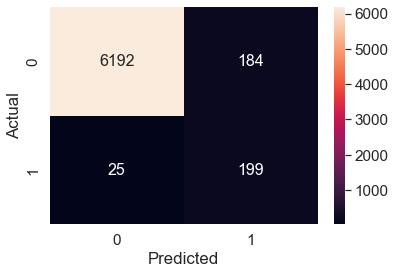

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      6376
           1       0.52      0.89      0.66       224

    accuracy                           0.97      6600
   macro avg       0.76      0.93      0.82      6600
weighted avg       0.98      0.97      0.97      6600



In [61]:
clfAda = AdaBoostClassifier(learning_rate=1.75,n_estimators=500,random_state=1)
clfAda.fit(X_ros, y_ros)

#Feature importance
importance = clfAda.feature_importances_
impDictAda=dict(zip(featureList, importance))
print("Most important Features")
print(dict(sorted(impDictAda.items(),key=lambda item: item[1],reverse=True)))

adaPredProb=clfAda.predict_proba(X_test)[:,1]
adaPred=clfAda.predict(X_test)
#roc
fpr3, tpr3, thresholds3= roc_curve(y_test, adaPredProb)
auc3 = round(roc_auc_score(y_test, adaPredProb), 4)

#scoring
accuracy=recall_score(y_test,adaPred)
print(accuracy)
finalScoreList['AdaBoost']=accuracy
#confusion matrix
cm = confusion_matrix(y_test,adaPred)
sns.set(font_scale=1.4) # for label size
ax=sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
ax.set(xlabel='Predicted',ylabel='Actual')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test,adaPred))

### Final tests and comparisons 
Let's test the best 3 tuned models with Recall Scores, ROC Curve, and see our most important features

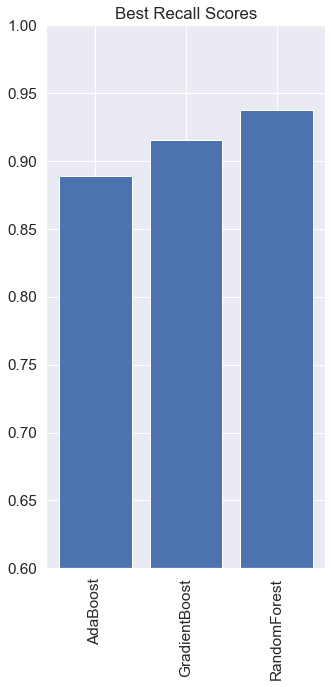

In [273]:
#see the best models
sort_by_value = dict(sorted(finalScoreList.items(), key=lambda item: item[1]))
plt.figure(figsize=(5,10))
plt.bar(*zip(*sort_by_value.items()))
plt.xticks(rotation='vertical')
plt.ylim(0.6,1.0)
plt.title('Best Recall Scores')
plt.show()
#we can see Random Forest had the highest score here

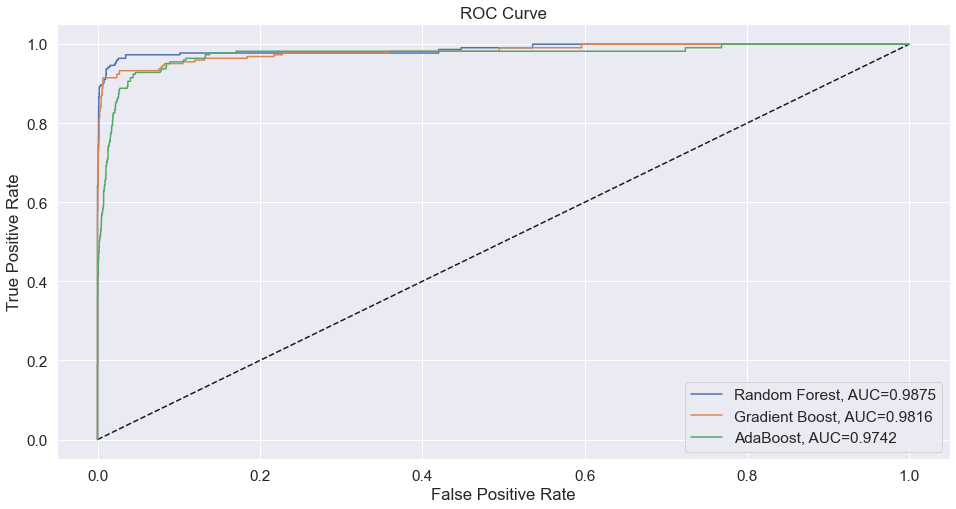

In [70]:
# Plot ROC curve
plt.figure(figsize=(16,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1,tpr1,label="Random Forest, AUC="+str(auc1))
plt.plot(fpr2,tpr2,label="Gradient Boost, AUC="+str(auc2))
plt.plot(fpr3,tpr3,label="AdaBoost, AUC="+str(auc3))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
#Random forest had highest ROC score here too

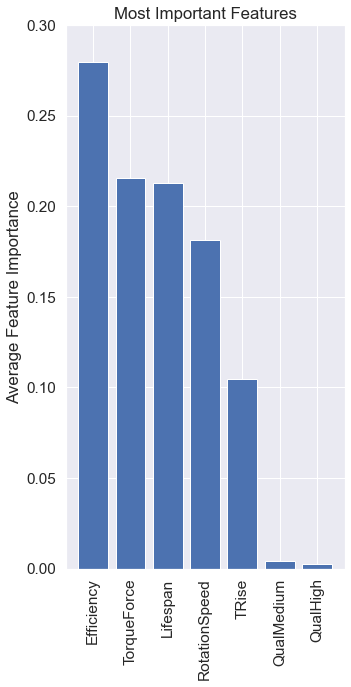

In [69]:
#Calculate average feature importance across 3 best models
dfDict = pd.DataFrame([impDictFor,impDictGrad,impDictAda])
answer = dict(dfDict.mean().sort_values(ascending = False))
#plot
plt.figure(figsize=(5,10))
plt.bar(*zip(*answer.items()))
plt.xticks(rotation='vertical')
plt.ylim(0.0,0.3)
plt.ylabel('Average Feature Importance')
plt.title('Most Important Features')
plt.show()

### Conclusion
Gradient Boost and KNN trade blows in accuracy and ROC score, but random forest remained the best.

We can conclude that Random Forest with the following parameters is the best model:

(bootstrap=False,max_depth=32,min_samples_split=10,min_samples_leaf=1,max_features='sqrt',n_estimators=300)

The 'Efficiency' feature we engineered was also the most important one for the models (on average)